# Week of 2025.05.12 


## TODO 
- [ ] Atmosphere model
    - [ ] Add lighthill tensor calculation and understand what is taking place. 
    - [ ] Read over Eric's paper and better understand. 

## 0.0 Review eruption

In [9]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

folder_name = "eruption_model"
file_name = "tungurahua_rad_5_v25_conduit"
iterations = 100

In [6]:
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iterations, viscosity_index=1, wall_friction_index=5, max_velocity=50, max_slip=60, max_tau=0.1, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=1)

HTML(ani.to_html5_video())

## 1.0 Observed infrasound data

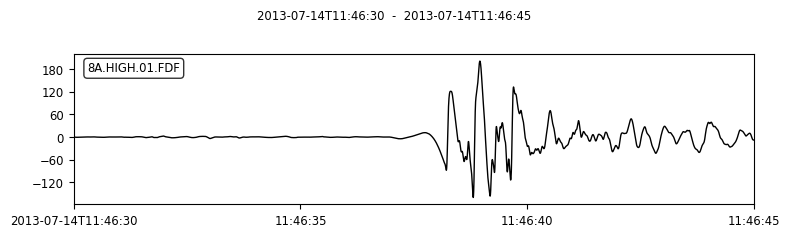

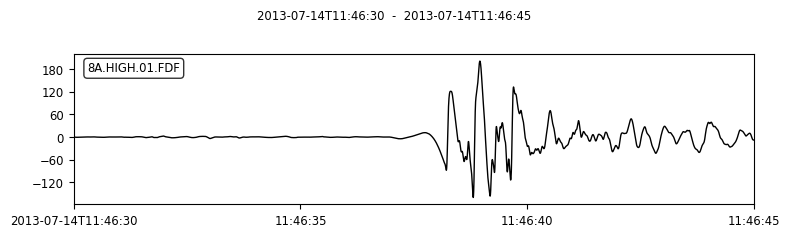

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import obspy
from obspy import read, Stream, UTCDateTime
from obspy.io.mseed.util import get_record_information

file_path = "/Users/paxton/git/volcano_sims/infrasound_data/8A.HIGH.2013-07-14.mseed"

st = read(file_path)

tr0 = st[0]
tr0_filtered = tr0.copy()

freqmin = 1
freqmax = 20
tr0_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

tr0_filtered.data = tr0_filtered.data * 1.589e-6 /  23e-6

t1 = UTCDateTime("2013-07-14T11:46:30")
t2 = UTCDateTime("2013-07-14T11:46:45")

tr0_filtered.trim(t1, t2)

tr0_filtered.plot()

## 2.0 monopole source simulation

The downside of the atmospheric coupling in quail is that the model is complicated and I don't fully understand it. As a small project, I am going to create a simple numerical solution for atmosphere based on treating the volcano as a monopole acoustic source where the pressure wave is a function purely of the ejected volume, which we consider to be incompressible. 

Eric shared [notes](https://drive.google.com/file/d/1khrmHWfoOqrcBjE533TtZirvnp9IIAc3/view?usp=sharing) on 3D acoustics, from which I will use the relation 

$$
p(r,t) = \frac{\rho \dot{Q}(t-r/c)}{4 \pi r * (2/3)}
$$

See more in-depth notes in my notes from [last week](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.05.05.experiments.html).

The monopole source produces unfiltered infrasound waves to the correct order of magnitude (~200 Pa) but not sufficiently precise to match the specific observed wave pattern. 

In [3]:
solver_func = get_local_solver_from_index_func(folder_name, file_name)

u_vec = []
t_vec = []
R = 50 # m

for i in range(0, int(iterations), 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2

N = 100
pressure_array = np.zeros((N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1500)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            if infrasound.point_in_volcano(x, y):
                pressure_array[j][i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[j][i] = infrasound.relative_pressure(t, x, y, t_vec, Q_dot_vec)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec[0:int(iterations)]), 
                    interval=200, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [20]:
from scipy import signal

pressure_at_2000 = []

for t in t_vec:
    pressure_at_2000.append(infrasound.relative_pressure(t, 2000, -1000, t_vec, Q_dot_vec))

fs = 10  # Sampling frequency (Hz)

# Step 2: Define band-pass filter parameters
lowcut = 1.0  # Lower cutoff frequency (Hz)
order = 5  # Filter order

# Normalize cutoff frequencies to Nyquist frequency (fs/2)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Step 3: Design Butterworth band-pass filter
b, a = signal.butter(order, low, btype='high')

p_relative_arr_2000_filtered = signal.filtfilt(b, a,  pressure_at_2000)


Text(0.02, 0.5, 'Pressure (Pa)')

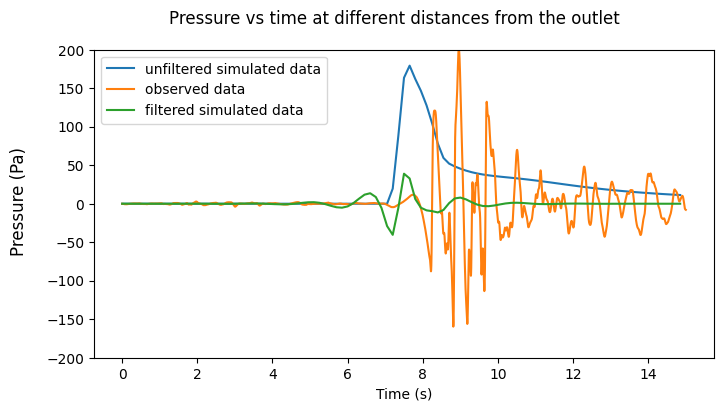

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.plot(t_vec, pressure_at_2000, label="unfiltered simulated data")
ax.plot(tr0_filtered.times(), tr0_filtered.data, label="observed data")
ax.plot(t_vec, p_relative_arr_2000_filtered, label="filtered simulated data")

ax.set_ylim(-200, 200)
ax.legend()
ax.set_xlabel("Time (s)")

fig.suptitle("Pressure vs time at different distances from the outlet")
fig.supylabel("Pressure (Pa)")

## 3.0 Review quail atmosphere model

Let's look at our model where we set the pressure to be constant and remove the gravity term. 

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 100

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm1")
solver2D_atm2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm2")
solver2D_atm3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm3")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
x2, p2_0 = mdtools.downsample(solver2D_atm2(0), plot_qty="Pressure")
x3, p3_0 = mdtools.downsample(solver2D_atm3(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    x2, p2 = mdtools.downsample(solver2D_atm2(frame), plot_qty="Pressure")
    x3, p3 = mdtools.downsample(solver2D_atm3(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    mdtools.plot_mean(x2, p2 - p2_0, clims)
    mdtools.plot_mean(x3, p3 - p3_0, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [4]:
import matplotlib.tri as tri

# Assume solver2D_from is available as in the original code
solver2D_1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm1")
solver2D_2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm2")
solver2D_3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm3") 


triangulation1 = tri.Triangulation(solver2D_1(0).mesh.node_coords[...,0],
                  solver2D_1(0).mesh.node_coords[...,1], 
                  triangles=solver2D_1(0).mesh.elem_to_node_IDs)

triangulation2 = tri.Triangulation(solver2D_2(0).mesh.node_coords[...,0],
                  solver2D_2(0).mesh.node_coords[...,1], 
                  triangles=solver2D_2(0).mesh.elem_to_node_IDs)

triangulation3 = tri.Triangulation(solver2D_3(0).mesh.node_coords[...,0],
                  solver2D_3(0).mesh.node_coords[...,1], 
                  triangles=solver2D_3(0).mesh.elem_to_node_IDs)
                  
trifinder1 = triangulation1.get_trifinder()
trifinder2 = triangulation2.get_trifinder()
trifinder3 = triangulation3.get_trifinder()

trifinders = [trifinder1, trifinder2, trifinder3]

p_relative_arr_200 = infrasound.get_p_series(200, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_500 = infrasound.get_p_series(500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_1500 = infrasound.get_p_series(1500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_2000 = infrasound.get_p_series(2000, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)

Element ID for point (200, 0): 92
Element ID for point (500, 0): 714
Element ID for point (1500, 0): 785
Element ID for point (2000, 0): 960


In [6]:
from scipy import signal

fs = 10  # Sampling frequency (Hz)

# Step 2: Define band-pass filter parameters
lowcut = 1.0  # Lower cutoff frequency (Hz)
order = 5  # Filter order

# Normalize cutoff frequencies to Nyquist frequency (fs/2)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Step 3: Design Butterworth band-pass filter
b, a = signal.butter(order, low, btype='high')

p_relative_arr_200_filtered = signal.filtfilt(b, a, p_relative_arr_200)
p_relative_arr_500_filtered = signal.filtfilt(b, a, p_relative_arr_500)
p_relative_arr_1500_filtered = signal.filtfilt(b, a, p_relative_arr_1500)
p_relative_arr_2000_filtered = signal.filtfilt(b, a, p_relative_arr_2000)

Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet (after filtering out anything below 1 Hz)')

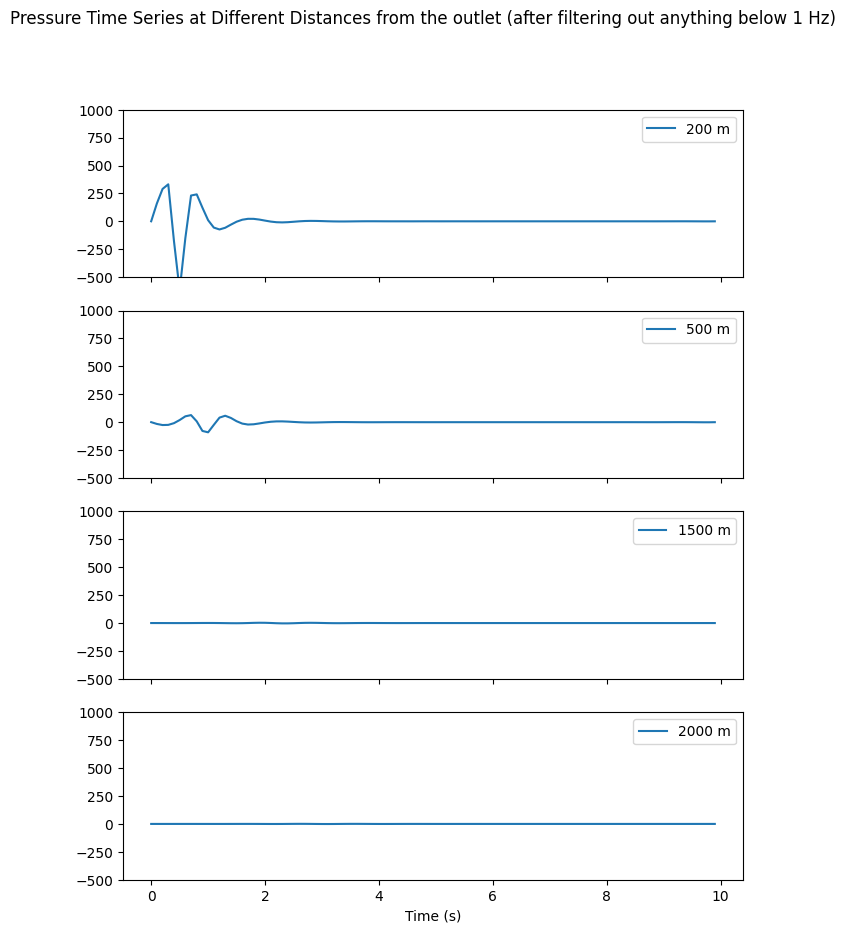

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_200_filtered, label="200 m")
axes[1].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_500_filtered, label="500 m")
axes[2].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1500_filtered, label="1500 m")
axes[3].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_2000_filtered, label="2000 m")

for ax in axes:
    ax.set_ylim(-5e2, 1e3)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet (after filtering out anything below 1 Hz)")

## 5.0 Lighthill accostic analogy theory

From Eric: 

> If we wanted to get really ambitious, then what we could do is implement the Lighthill acoustic analogy theory. See section 3.6.2 in Fred's thesis, specifically equations (3.129) and (3.130). Fred has code to calculate the Lighthill stress tensor, which is a source term. We would then take that source term and convolve it with the linear acoustics Green's function. In fact, that could later be replaced with a fully coupled acoustic-elastic Green's function from another code (SPECFEM) that Mario has used. There are many reasons to do this: first, it only requires using Fred's code to get the flow field around the vent correctly, and it doesn't matter if there is too much damping in the numerics to accurately model acoustic propagation beyond a few hundred meters. Second, we know that the ground is not rigid, but elastic, as Fred's code assumes. The acoustic-elastic Green's functions will allow us to use all parts of the seismograms (right now we ignore the displacements caused by the strong infrasound blast). Mario and I have discussed this as a possible extension of his work.

### Notes on Lighthill Accoustic Analogy,  [Fred's thesis ](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L) section 3.6.2

- Fred models 2150m conduit with 50m radius 
- Model the top 150m of the conduit as part of a axissymmetric 2d domain. 

Interestingly, Fred was able to get his model to create a burst of pressure of the right order of magnitude for the Tungurahua eruption:

> In comparison, our model prediction for
a sensor placed at a similar location on the flank 2 km from the vent produces a pressure peak of
a similar duration and order of magnitude as the Tungurahua Vulcanian blast, despite not having
tuned our parameters to fit the Tungurahua eruption.

Light hill's acoustic analogy is established by manipulating the governing equation for compresable flow to obtain 

$$
\frac{1}{a_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = \nabla \cdot (\nabla \cdot \bf{T})
$$

where $a_0$ is the speed of sound in the atmosphere and $\bf{T}$ is the Lighthill stres sensor. 

The inviscid Lighthill stress tensor comprises a convective term plus another nonlinear term.

$$
\bf{T} = \rho \bf{u} \otimes \bf{u} + (p - a_0^2 \rho) \bf{I}
$$

Note:

$\rho u_i u_j$ - Reynolds stress 

$p - a_0^2 \rho$ - Thermodynamic pressure term. 

As a simplification, we could assume $p = a_0^2 \rho$ which would allow us to calculate each element of the tensor as:

$$
T_{ij} = \rho u_i u_j
$$


### Notes from talking with Eric 05/07

**1. Define the source**

$$ \frac{1}{c_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = S(\bf{x}, t) $$

**2. Compute Green's function**

First, let's review what a [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) is. A Green's function allows us to rewrite the problem as a sum of source points.

$$ 
\frac{1}{c_0^2} \frac{\partial^2 G(\bf(x), \bf(y), t)}{\partial t^2} + \nabla^2 G = \delta^{(3)}(\bf{x} - \bf{y})\delta(t)
$$

The Green's function, written for all space looks something like

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{2 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
p(\bf{x}, t) = \int \int_V G(\bf{x}, \bf{y}, t-\tau) S(\bf{y}, \tau) d^3y d \tau
$$

**3. How do we evaluate the convolution numerically.**

We would probably work in the frequency domain. Tends to be easier. So

$$
p(\bf{x}, \omega) = \int_V G(\bf{x}, \bf{y}, \omega) S(\bf{y}, \tau) d^3y d
$$


Consider using reciprocity. Specfem. 

Fred has code to get the source term. Talk to him about using that. Then you just need to compute the Green's function and evaluate the convolution numerically. 


### Notes from [paper](https://drive.google.com/file/d/18dS_SlExCoOoAUUXYuxTV1Gkl9PyO_4f/view?usp=sharing) that Eric and Leighton worked on

In this paper Eric shows that general equation for pressure can be simplified when you assume liner wave propagation (which reduces the lighthill stress tensor to zero):

$$
\Delta p (x, t) = \frac{1}{4 \pi} (\frac{\partial}{\partial t} \int_s [\frac{\rho v \cdot n}{r}]dS - \frac{\partial}{\partial x_j} \int_S n_i [\frac{p_{ij}}{r}]dS)
$$


Which in turn can be expressed in the frequency domain as:

$$
\Delta \hat{p} (x, \omega) = \frac{1}{4 \pi} i \omega \int_S \frac{\hat{p}\hat{v_n}}{|x - x'|} \exp(- i \omega \frac{|x - x'|}{c}) dS - \frac{1}{4 \pi} \int_S \frac{\hat{p} n_i}{|x - x'|^2} ( \frac{- i \omega (x_i - x_i')}{c} + \frac{x_i - x_i'}{|x - x'|}) \exp( - i \omega \frac{|x - x'|}{c}) dS 
$$



**Does this imply that I should experiment with the monopole and dipole source, but without populating a lighthill stress tensor?**


## 5.1 Calculating light hill stress tensor 


In [ ]:
from helper_code.lighthill import lighthill

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("eruption_model", f"test_infrasound_v26_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 2000, 400)
base_y = np.linspace(-300, 4000, 401)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1,2,3]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,100,1)

In [ ]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1,2,3]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

In [ ]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))


t_range = np.linspace(0, 15, T_interp.shape[0])
